http://scikit-image.org/docs/dev/auto_examples/edges/plot_active_contours.html
http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_morphsnakes.html

<h1> Active Contour Model </h1>
The principle is to minimize an image energy and a shape energy
However, a beginning contour is needed

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour
import cv2
from skimage.feature import peak_local_max
import scipy.ndimage as ndi
from skimage.filters import threshold_yen

# Load an example image
img = cv2.imread('test_image.tif')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

thresh = threshold_yen(img)
binary = img > thresh
distance = ndi.distance_transform_edt(binary)
maxima = peak_local_max(distance,indices=False,footprint=np.ones((40,110)),labels=binary)
plt.figure(1,figsize=(12,12))
plt.title('local maxima',size=20)
plt.imshow(binary,cmap='Greys')
plt.spy(maxima,marker='x',markersize=8,markeredgewidth=5,color='r')

In [18]:
np.where(maxima==True)

(array([ 53,  53,  67,  75,  75,  76,  87,  87,  91,  92,  93,  93,  98,
        142, 143, 173, 175, 181, 181, 182, 182, 198, 199, 217, 218, 222,
        224, 225, 227, 259, 259, 259, 262, 262, 263, 263, 267, 271],
       dtype=int64),
 array([504, 505, 629, 267, 268, 268,  92,  93, 358, 685, 624, 686, 433,
        544, 355, 408, 697, 298, 580, 106, 580, 828, 828, 740, 601, 193,
        324, 324, 484, 231, 232, 444,  55,  56,  63,  64, 787, 627],
       dtype=int64))

[0, 900, 300, 0]

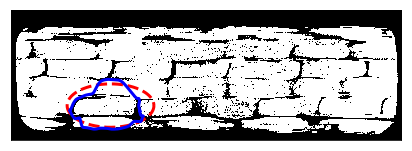

In [2]:
s = np.linspace(0, 2*np.pi, 400)
x = 230 + 100*np.cos(s)
y = 220 + 50*np.sin(s)
init = np.array([x, y]).T


snake = active_contour(gaussian(binary, 3), init)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(binary, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

[0, 900, 300, 0]

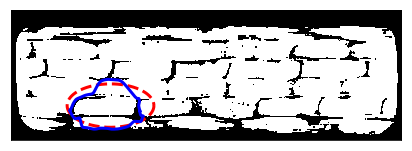

In [3]:
s = np.linspace(0, 2*np.pi, 400)
x = 230 + 100*np.cos(s)
y = 220 + 50*np.sin(s)
init = np.array([x, y]).T

kernel = np.ones((3,3),np.uint8)
closing = cv2.morphologyEx(np.uint8(binary),cv2.MORPH_CLOSE,kernel)
snake = active_contour(gaussian(binary, 3), init)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(closing, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])



As our clusters are clumped together and badly delimited, active contour methods don't work really well.

<h1> Morphological snake </h1>
Same behaviour as active contour but use morphological operator instead of solving a PDE.

MorphGAC is suitable for images with visible contours, even when these contours might be noisy, cluttered, or partially unclear. It requires, however, that the image is preprocessed to highlight the contours. This can be done using the function inverse_gaussian_gradient, although the user might want to define their own version. The quality of the MorphGAC segmentation depends greatly on this preprocessing step.

On the contrary, MorphACWE works well when the pixel values of the inside and the outside regions of the object to segment have different averages. Unlike MorphGAC, MorphACWE does not require that the contours of the object are well defined, and it works over the original image without any preceding processing. This makes MorphACWE easier to use and tune than MorphGAC.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)

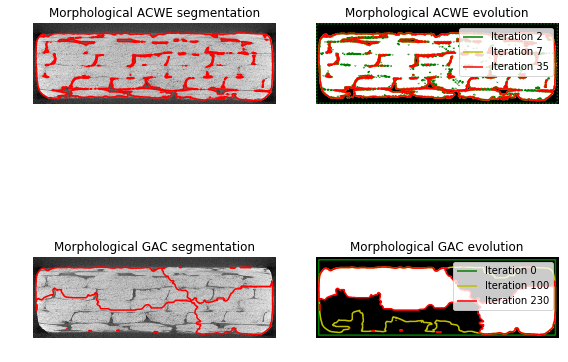

In [27]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


# Morphological ACWE
img = cv2.imread('test_image.tif')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
image = img_as_float(img)

# Initial level set
init_ls = checkerboard_level_set(image.shape, 6)
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(image, 35, init_level_set=init_ls,
                             iter_callback=callback)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[2], [0.5], colors='g')
contour.collections[0].set_label("Iteration 2")
contour = ax[1].contour(evolution[7], [0.5], colors='y')
contour.collections[0].set_label("Iteration 7")
contour = ax[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 35")
ax[1].legend(loc="upper right")
title = "Morphological ACWE evolution"
ax[1].set_title(title, fontsize=12)


# Morphological GAC
image = img_as_float(img)
gimage = inverse_gaussian_gradient(image)

# Initial level set
init_ls = np.zeros(image.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_geodesic_active_contour(gimage, 230, init_ls,
                                           smoothing=1, balloon=-1,
                                           threshold=0.69,
                                           iter_callback=callback)

ax[2].imshow(image, cmap="gray")
ax[2].set_axis_off()
ax[2].contour(ls, [0.5], colors='r')
ax[2].set_title("Morphological GAC segmentation", fontsize=12)

ax[3].imshow(ls, cmap="gray")
ax[3].set_axis_off()
contour = ax[3].contour(evolution[0], [0.5], colors='g')
contour.collections[0].set_label("Iteration 0")
contour = ax[3].contour(evolution[100], [0.5], colors='y')
contour.collections[0].set_label("Iteration 100")
contour = ax[3].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 230")
ax[3].legend(loc="upper right")
title = "Morphological GAC evolution"
ax[3].set_title(title, fontsize=12)

fig.tight_layout()
plt.show()

<h1> Conclusion </h1>
The edges do not seem to be neat enough to use an active contour method. However we could use one on the image to extract the whole sample from the background.